In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [52]:
# Input
start = datetime.datetime( 2016, 7, 1)
end = datetime.datetime( 2016, 7, 7, 1, 0)
interval = 300 # interval of market operation
file_WS = 'glm_generation_Austin/Ercot_LZ_SOUTH.csv'

In [56]:
market_intervals = pd.date_range(start,end,freq=str(int(interval/60))+'min')
market_intervals #the first hour in 5 minute increments
index = len(market_intervals)
print(len(market_intervals))

1741


In [57]:
df_WS = pd.read_csv(file_WS,parse_dates=True,index_col=[0]) # For year 2016
df_WS.head()
df_WS = df_WS[~df_WS.index.duplicated(keep='last')]
#change units, divide by 1000
df_WS = df_WS/1000
df_WS = df_WS.loc[market_intervals]
assert len(df_WS) == len(market_intervals)
len(df_WS)

1741

In [58]:
# Initialize parameters
prices = df_WS.RT
T = len(prices)
assert T == len(market_intervals)

# Initialize variables
SOC = cp.Variable((T+1,))
x = cp.Variable((T,))
#profit = cp.Variable(1,)

# Initialize constraints
constraints = [SOC[0]==2.]
constraints += [SOC[T]==2.]

for t in range(T):
    #constraints += [(-1<=x[t]), (x[t]<=1), 1<=SOC[t], SOC[t]<=5, SOC[t+1]==1*SOC[t]+x[t]/12.]
    constraints += [-1.<=x[t], x[t]<=1., 1.<=SOC[t], SOC[t]<=5., SOC[t+1]==SOC[t]+(x[t]/12)]

# Objective function
obj = cp.sum(cp.multiply(prices,-x)) # Discharging : x < 0 --> positive profits
obj = cp.Maximize(obj)

In [59]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = (prob.solve())/12 #returns optimal value = prob.value
print(profits)

0.5373108332811204


In [26]:
print(SOC.value)

[2.         1.91666667 1.83333334 ... 1.83333333 1.91666667 2.        ]


In [27]:
print(x.value)

[-0.99999998 -0.99999998 -0.99999998 ...  1.          1.
  1.        ]


In [29]:
# Print output and solution characteristics
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

# is it ok that the x array contains values other than -1, 0, 1?
#for the test, first half is positive because charging, and second half is discharging

status: optimal
optimal value 6.447729999373445
optimal var [-0.99999998 -0.99999998 -0.99999998 ...  1.          1.
  1.        ]


In [60]:
def visualize_battery_dispatch(SOC,x,prices,market_intervals):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    #plot1 = ax.plot(data.timestamp, data.RT, color='xkcd:sky blue', label='RT')
    #plot1 = ax.step(data.timestamp, data.RT, where="post", color='xkcd:sky blue', label='RT')
    plot1 = ax.step(market_intervals, prices, where="post", color='xkcd:sky blue', label='RT')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
#    ax.set_xlim(xmin=data.iloc[0]['timestamp'], xmax=data.iloc[-1]['timestamp']+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
#    ax.set_ylim(-1,5)

    ax2 = ax.twinx()
    #plot2 = ax2.plot(data.timestamp, data.SOC_t, color='orange', label='SOC')
    plot2 = ax2.step(market_intervals, SOC.value[:-1], where="post", color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    #plot3 = ax3.plot(data.timestamp, data.dispatch, color='red', label='load')
    plot3 = ax3.step(market_intervals, x.value, where="post", color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)


    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-60-e4f728fdd651>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


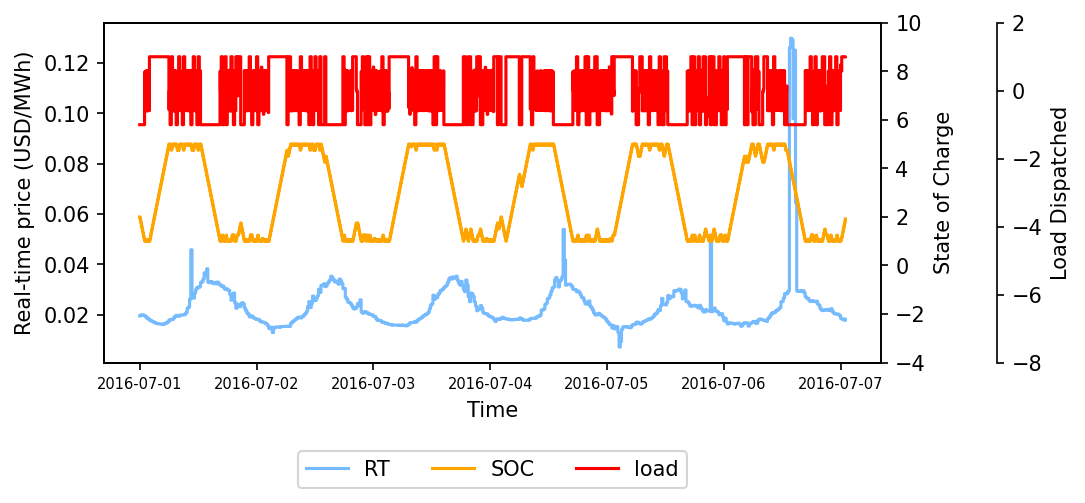

In [61]:
#visualize_battery_dispatch(df_store.iloc[9*12:12*12])

visualize_battery_dispatch(SOC,x,prices,market_intervals)

In [20]:
# pd.daterange(.rand(), end_whichis_96intervalslater, freq=5)
xs = []
ys = []
for i in range(5000):
    begin_index = rd.sample(range(len(market_intervals)), 1)[0]
    sample_times = market_intervals[begin_index:begin_index+96]
    df_store_sample = df_store[df_store.timestamp.isin(sample_times)]
    
    ys.append(df_store_sample.iloc[:48].RT.mean() - df_store_sample.iloc[48:].RT.mean())
    xs.append(df_store_sample.iloc[:48].dispatch.mean() - df_store_sample.iloc[48:].dispatch.mean())

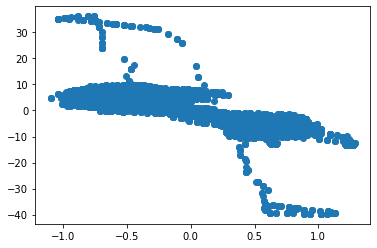

In [21]:
#doesn't dispatch when it is supposed to
plt.scatter(xs, ys)